In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# Parse output of end-to-end benchmarks
class MageMeasurement(object):
    def __init__(self, f):
        lines = []
        for line in f:
            tokens = line.split()
            if len(tokens) >= 2 and tokens[1] == "(ns)":
                stats = Stats(line)
                if stats.name not in self.stats:
                    self.stats[stats.name] = []
                self.stats[stats.name].append(stats.total)
            elif len(tokens) == 3 and tokens[0] == "Timer:" and tokens[2] == "ns":
                self.time_for_computation_ns = int(tokens[1])
                self.time_for_computation_ms = self.time_for_computation_ns / 1000000.0
            lines.append(line)
        
        tokens = lines[-1].split()
        if len(tokens) == 2 and tokens[1] == "ms":
            self.total_time_ms = int(tokens[0])
        else:
            assert(False)
            self.total_time_ms = self.time_for_computation_ns / 1000000.0 # Hack to produce graphs with some missing data

class EMPMeasurement(object):
    def __init__(self, f):
        lines = []
        for line in f:
            lines.append(line)
        assert(len(lines) == 4)
        assert(lines[0] == "connected\n")
        assert(lines[2] == "PASS\n")
        self.time_for_computation_ms = int(lines[1].split()[1])
        self.total_time_ms = int(lines[3].split()[1])
        
class PlanningMeasurement(object):
    def __init__(self, f):
        lines = []
        for line in f:
            lines.append(line)
        assert(len(lines) == 6)
        phase_times = lines[5].split()
        self.placement_ms = int(phase_times[3])
        self.replacement_ms = int(phase_times[4])
        self.scheduling_ms = int(phase_times[5])
        self.total_ms = self.placement_ms + self.replacement_ms + self.scheduling_ms
        
class SEALMeasurement(object):
    def __init__(self, f):
        lines = []
        for line in f:
            lines.append(line)
        assert(len(lines) == 1)
        self.total_time_ms = int(lines[0].split()[0])

class Stats(object):
    def __init__(self, line):
        tokens = line.strip().split()
        self.name = tokens[0]
        self.unit = tokens[1][1:-2]
        assert(tokens[3] == "min")
        assert(tokens[6] == "avg")
        assert(tokens[9] == "max")
        assert(tokens[12] == "count")
        assert(tokens[15] == "sum")
        self.total = int(tokens[17])
        
def parse_planning_log(f):
    last_line = None
    for line in f:
        last_line = line
    tokens = last_line.split()
    return tuple(int(x) for x in tokens[3:])

In [3]:
def generate_filename(prefix, program, scenario, tag):
    if isinstance(tag, int):
        tag = "t{0}".format(tag)
    return "{0}_{1}_{2}_{3}.log".format(prefix, program, scenario, tag)

def parse_emp_measurement_file(filename):
    with open(filename) as f:
        return EMPMeasurement(f)

def parse_mage_measurement_file(filename):
    with open(filename) as f:
        return MageMeasurement(f)
    
def parse_seal_measurement_file(filename):
    with open(filename) as f:
        return SEALMeasurement(f)
    
def parse_planning_measurement_file(filename):
    with open(filename) as f:
        return PlanningMeasurement(f)
    
def parse_planning_log_file(filename):
    with open(filename) as f:
        return parse_planning_log(f)

    
allowable_locations = ("oregon", "iowa")

def parse_log_directory(directory):
    logs = {}
    machine_directories = !ls {directory}
    for mdir in machine_directories:
        try:
            machine_id = int(mdir)
        except ValueError:
            if mdir in allowable_locations:
                machine_id = mdir
            else:
                print("Skipping directory {0}", os.path.join("directory", mdir))
                continue
            
        machine_logs = logs.setdefault(machine_id, {})
            
        log_files = !ls {os.path.join(directory, mdir)}
        for log_file in log_files:
            if log_file.endswith(".log") or log_file.endswith(".planning"):
                log_path = os.path.join(directory, mdir, log_file)
                
                parts = log_file.split(".")
                extension = parts[-1]
                name = ".".join(parts[:-1])
                
                ext_logs = machine_logs.setdefault(extension, {})
                
                tokens = name.split("_")
                if len(tokens) < 6:
                    print("Skipping(1) file {0}".format(log_path))
                    continue
                if tokens[0] == "wan":
                    location = tokens[1]
                    try:
                        workers_per_node = int(tokens[2])
                        ot_pipeline_depth = int(tokens[3])
                        ot_num_daemons = int(tokens[4])
                        size = int(tokens[-4])
                    except ValueError as ve:
                        print(ve)
                        print("Skipping(2) file {0}".format(log_path))
                        continue
                    problem = "_".join(tokens[5:-4])
                    scenario = tokens[-3]
                    tag = tokens[-2]
                    worker = tokens[-1]
                    experiments = ext_logs.setdefault("wan", {}).setdefault(location, {}).setdefault(workers_per_node, {}).setdefault(problem, {}).setdefault(size, {}).setdefault(ot_pipeline_depth, {}).setdefault(ot_num_daemons, {}).setdefault(scenario, {}).setdefault(worker, {})
                else:
                    experiment = "_".join(tokens[:2])
                    try:
                        size = int(tokens[-3])
                    except ValueError:
                        print("Skipping file {0}".format(log_path))
                        continue
                    problem = "_".join(tokens[2:-3])
                    scenario = tokens[-2]
                    tag = tokens[-1]
                    experiments = ext_logs.setdefault(experiment, {}).setdefault(problem, {}).setdefault(size, {}).setdefault(scenario, {})
                if tag in experiments:
                    print("Skipping {0} (duplicate for {1})".format(log_path, (experiment, problem, size, scenario, tag)))
                    continue
                    
                try:
                    if scenario in ("os", "unbounded", "mage"):
                        if extension == "log":
                            parsed = parse_mage_measurement_file(log_path)
                        elif extension == "planning":
                            parsed = parse_planning_measurement_file(log_path)
                    elif scenario == "emp":
                        parsed = parse_emp_measurement_file(log_path)
                    elif scenario == "seal":
                        parsed = parse_seal_measurement_file(log_path)
                    else:
                        print("Skipping {0} (unknown scenario {1})".format(log_path, scenario))
                        continue
                    experiments[tag] = parsed
                except AssertionError as ae:
                    print("Skipping {0} (assertion failure: {1})".format(log_path, str(ae)))
    return logs

Baseline Experiments (Figures 6 and 7)
================================

In [4]:
baseline_directory = "logs-2"

In [5]:
baseline_logs = parse_log_directory(baseline_directory)

In [6]:
baseline_unbounded_style = {"label": "Unbounded", "color": "blue", "marker": "s", "ls": "-", "linewidth": 3}       
baseline_mage_style = {"label": "MAGE 1 GiB", "color": "orange", "marker": "^", "ls": "--"}
baseline_os_style = {"label": "OS 1 GiB", "color": "green", "marker": "o", "ls": "-"}
baseline_emp_style = {"label": "EMP 1 GiB", "color": "red", "marker": "v", "ls": "-."}
baseline_seal_style = {"label": "SEAL 1 GiB", "color": "red", "marker": "v", "ls": "-."}

In [7]:
def draw_halfgates_baseline_graph(sizes):
    plt.figure(figsize = (3, 2))
    
    benchmark_data = baseline_logs[0]["log"]["halfgates_baseline"]["merge_sorted"]
    def get_data(scenario, sizes, tag):
        result = []
        for size in sizes:
            time_s = benchmark_data[size][scenario][tag].time_for_computation_ms / 1000.0
            result.append(time_s)
        return result

    plt.plot(sizes, get_data("unbounded", sizes, "t1"), **baseline_unbounded_style)
    plt.plot(sizes, get_data("os", sizes, "t1"), **baseline_os_style)
    plt.plot(sizes, get_data("mage", sizes, "t1"), **baseline_mage_style)
    plt.plot(sizes, get_data("emp", sizes, "t1"), **baseline_emp_style)

    plt.xlim(0, sizes[-1])
    
    plt.xlabel("Problem Size (Records Per Party)")
    plt.ylabel("Time (s)")
    
def draw_ckks_baseline_graph(sizes):
    plt.figure(figsize = (3, 2))
    
    benchmark_data = baseline_logs[0]["log"]["ckks_baseline"]["real_statistics"]
    def get_data(scenario, sizes, tag):
        result = []
        for size in sizes:
            time_s = benchmark_data[size][scenario][tag].total_time_ms / 1000.0
            result.append(time_s)
        return result

    plt.plot(sizes, get_data("unbounded", sizes, "t1"), **baseline_unbounded_style)
    plt.plot(sizes, get_data("os", sizes, "t1"), **baseline_os_style)
    plt.plot(sizes, get_data("mage", sizes, "t1"), **baseline_mage_style)
    plt.plot(sizes, get_data("seal", sizes, "t1"), **baseline_seal_style)

    plt.xlim(0, sizes[-1])
    
    plt.xlabel("Problem Size (Number of Elements)")
    plt.ylabel("Time (s)")

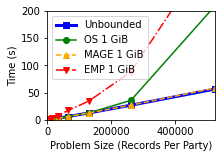

In [8]:
draw_halfgates_baseline_graph(tuple(2 ** i for i in range(13, 20)))
plt.ylim(0, 200)

plt.legend(loc=2)
plt.show()

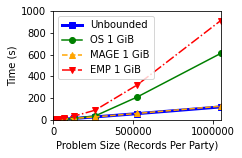

In [9]:
draw_halfgates_baseline_graph(tuple(2 ** i for i in range(13, 21)))
plt.ylim(0, 1000)

plt.xticks((0, 500000, 1000000))
plt.ticklabel_format(style = "plain")

plt.legend(loc=2)
plt.show()

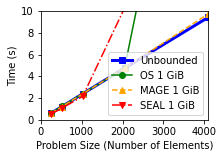

In [10]:
draw_ckks_baseline_graph(tuple(2 ** i for i in range(8, 13)))
plt.ylim(0, 10)

plt.legend()
plt.show()

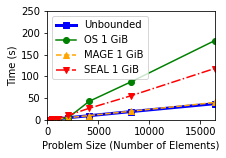

In [11]:
draw_ckks_baseline_graph(tuple(2 ** i for i in range(8, 15)))
plt.ylim(0, 250)

plt.legend()
plt.show()

Single-Node Experiments
=====================

In [12]:
single_node_directory = "logs-2"

In [13]:
single_node_logs = parse_log_directory(single_node_directory)

In [14]:
barwidth = 0.2
errbarsize = 3
styles = [{"label": "Unbounded", \
            "width": barwidth, "capsize": errbarsize, "color": "blue", "hatch": "", "edgecolor": "black"},          
          {"label": "MAGE 1 GiB", \
           "width": barwidth, "capsize": errbarsize, "color": "white", "hatch": "..", "edgecolor": "black"},
          {"label": "OS 1 GiB", \
           "width": barwidth, "capsize": errbarsize, "color": "white", "hatch": "\\\\", "edgecolor": "black"}]

In [15]:
def draw_workloads_plot(experiments, graph_data, experiment_display_names):
    x = np.arange(0, len(experiments))
    unbounded_err = [[(graph_data[e]["unbounded"][2] - graph_data[e]["unbounded"][1]) / graph_data[e]["unbounded"][2] for e in experiments], [(graph_data[e]["unbounded"][3] - graph_data[e]["unbounded"][2]) / graph_data[e]["unbounded"][2] for e in experiments]]
    plt.bar(x - barwidth, [graph_data[e]["unbounded"][2] / graph_data[e]["unbounded"][2] for e in experiments], yerr = unbounded_err, **styles[0])
    mage_err = [[(graph_data[e]["mage"][2] - graph_data[e]["mage"][1]) / graph_data[e]["unbounded"][2] for e in experiments], [(graph_data[e]["mage"][3] - graph_data[e]["mage"][2]) / graph_data[e]["unbounded"][2] for e in experiments]]
    plt.bar(x, [graph_data[e]["mage"][2] / graph_data[e]["unbounded"][2] for e in experiments], yerr = mage_err, **styles[1])
    os_err = [[(graph_data[e]["os"][2] - graph_data[e]["os"][1]) / graph_data[e]["unbounded"][2] for e in experiments], [(graph_data[e]["os"][3] - graph_data[e]["os"][2]) / graph_data[e]["unbounded"][2] for e in experiments]]
    plt.bar(x + barwidth, [graph_data[e]["os"][2] / graph_data[e]["unbounded"][2] for e in experiments], yerr = os_err, **styles[2])
    
    plt.xticks(x, experiment_display_names)
    plt.ylabel("Time (Normalized\nby Unbounded)")

In [16]:
hg_experiments = (("merge_sorted", 1048576), ("full_sort", 1048576), ("loop_join", 2048), ("matrix_vector_multiply", 8192), ("binary_fc_layer", 16384))
ckks_experiments = (("real_sum", 65536), ("real_statistics", 16384), ("real_matrix_vector_multiply", 256), ("real_naive_matrix_multiply", 128), ("real_tiled_matrix_multiply", 128))

experiments = hg_experiments + ckks_experiments
experiment_display_names = ("merge\nn = 1048576", "sort\nn = 1048576", "ljoin\nn = 2048", "mvmul\nn = 8192", "binfclayer\nn = 16384", "rsum\nn = 65536", "rstats\nn = 16384", "rmvmul\nn = 256", "n_rmatmul\nn = 128", "t_rmatmul\nn = 128")

merge & 170.7 & 577.0 & 180.5 & 3.2 & 6.0\%
sort & 1355.8 & 1991.0 & 1366.9 & 1.5 & 1.0\%
ljoin & 49.9 & 343.9 & 58.1 & 5.9 & 16.0\%
mvmul & 310.9 & 398.8 & 314.0 & 1.3 & 1.0\%
binfclayer & 25.3 & 105.4 & 29.6 & 3.6 & 17.0\%
rsum & 19.7 & 194.4 & 28.4 & 6.8 & 45.0\%
rstats & 37.2 & 167.1 & 38.1 & 4.4 & 3.0\%
rmvmul & 96.0 & 504.2 & 99.1 & 5.1 & 3.0\%
n_rmatmul & 1474.5 & 5575.5 & 1580.1 & 3.5 & 7.0\%
t_rmatmul & 1509.0 & 2203.7 & 1531.2 & 1.4 & 1.0\%


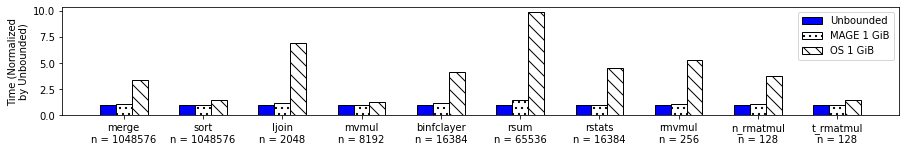

In [17]:
plt.figure(figsize = (15, 2))

# TODO: Support multiple trials done in parallel across different pairs of machines
benchmark_data = single_node_logs[0]["log"]["single_machine"]
graph_data = {}
for i, e in enumerate(experiments):
    graph_data[e] = {}
    print(experiment_display_names[i].split("\n")[0], end = "")
    for scenario in ("unbounded", "os", "mage"):
        total_times = tuple(m.total_time_ms / 1000.0 for tag, m in benchmark_data[e[0]][e[1]][scenario].items())
        assert len(total_times) > 0
        graph_data[e][scenario] = np.percentile(total_times, (0, 25, 50, 75, 100))
        print(" &", round(np.median(total_times), 1), end="")
    print(" &", round(graph_data[e]["os"][2] / graph_data[e]["mage"][2], 1), end="")
    print(" &", round((graph_data[e]["mage"][2] / graph_data[e]["unbounded"][2] - 1) * 100, 0), end="\\%")
    print()

draw_workloads_plot(experiments, graph_data, experiment_display_names)

# Uncomment this line for the scale to match the one in the figure in the paper.
# plt.ylim(0, 11)

plt.legend()
plt.show()

In [18]:
# TODO: Support multiple trials done in parallel across different pairs of machines
planning_data = single_node_logs[0]["planning"]["single_machine"]
for i, e in enumerate(experiments):
    graph_data[e] = {}
    print(experiment_display_names[i].split("\n")[0], end = "")
    planning_times = tuple(m.total_ms / 1000.0 for tag, m in planning_data[e[0]][e[1]]["mage"].items())
    assert len(planning_times) > 0
    graph_data[e][scenario] = np.percentile(planning_times, (0, 25, 50, 75, 100))
    median = np.median(planning_times)
    if median < 0.1:
        rounded_median = round(median, 3)
    elif median < 1:
        rounded_median = round(median, 2)
    else:
        rounded_median = round(median, 1)
    print(" &", rounded_median, end="\n")

merge & 41.3
sort & 405.4
ljoin & 6.8
mvmul & 58.2
binfclayer & 79.9
rsum & 0.036
rstats & 0.03
rmvmul & 0.072
n_rmatmul & 2.2
t_rmatmul & 2.7


p = 4 Parallelism Experiments
========================

In [19]:
multi_node_directory = "logs-8"

In [20]:
multi_node_logs = parse_log_directory(multi_node_directory)

In [21]:
hg_experiments_4 = (("merge_sorted", 4194304), ("full_sort", 4194304), ("loop_join", 4096), ("matrix_vector_multiply", 16384), ("binary_fc_layer", 32768))
ckks_experiments_4 = (("real_sum", 262144), ("real_statistics", 65536), ("real_matrix_vector_multiply", 512), ("real_naive_matrix_multiply", 256), ("real_tiled_matrix_multiply", 256))

experiments_4 = hg_experiments_4 + ckks_experiments_4
experiment_4_display_names = ("merge\nn = 4194384", "sort\nn = 4194384", "ljoin\nn = 4096", "mvmul\nn = 16384", "binfclayer\nn = 32768", "rsum\nn = 262144", "rstats\nn = 32768", "rmvmul\nn = 512", "n_rmatmul\nn = 256", "t_rmatmul\nn = 256")

merge & 160.0 & 1714.3 & 189.8 & 9.0 & 19.0\%
sort & 1266.0 & 5818.8 & 1692.0 & 3.4 & 34.0\%
ljoin & 37.6 & 480.7 & 49.9 & 9.6 & 33.0\%
mvmul & 258.5 & 471.6 & 249.6 & 1.9 & -3.0\%
binfclayer & 29.0 & 141.9 & 35.4 & 4.0 & 22.0\%
rsum & 22.6 & 269.1 & 30.8 & 8.8 & 36.0\%
rstats & 39.7 & 232.1 & 41.3 & 5.6 & 4.0\%
rmvmul & 102.8 & 686.0 & 107.4 & 6.4 & 4.0\%
n_rmatmul & 2976.2 & 24842.6 & 3303.8 & 7.5 & 11.0\%
t_rmatmul & 3008.7 & 5784.0 & 3087.0 & 1.9 & 3.0\%


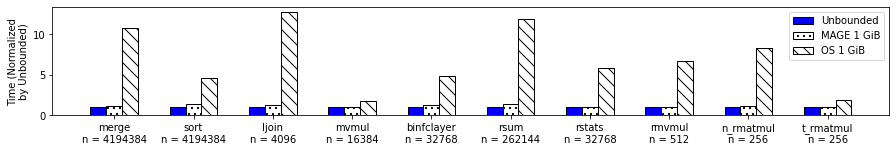

In [22]:
plt.figure(figsize = (15, 2))

# TODO: Support multiple trials done in parallel across different pairs of machines
graph_data = {}
for i, e in enumerate(experiments_4):
    graph_data[e] = {}
    print(experiment_4_display_names[i].split("\n")[0], end = "")
    for scenario in ("unbounded", "os", "mage"):
        instances_per_tag = {}
        for machine in (0, 1, 2, 3):
            machine_trials = multi_node_logs[machine]["log"]["workers_4"][e[0]][e[1]][scenario]
            for tag, m in machine_trials.items():
                instances_per_tag.setdefault(tag, []).append(m)
                
        total_times = []
        for tag, machine_exps in instances_per_tag.items():
            assert len(machine_exps) == 4
            total_times.append(max(m.total_time_ms / 1000.0 for m in machine_exps))
        assert len(total_times) > 0
        graph_data[e][scenario] = np.percentile(total_times, (0, 25, 50, 75, 100))
        print(" &", round(np.median(total_times), 1), end="")
    print(" &", round(graph_data[e]["os"][2] / graph_data[e]["mage"][2], 1), end="")
    print(" &", round((graph_data[e]["mage"][2] / graph_data[e]["unbounded"][2] - 1) * 100, 0), end="\\%")
    print()

draw_workloads_plot(experiments_4, graph_data, experiment_4_display_names)

# Uncomment this line for the scale to match the one in the figure in the paper.
# plt.ylim(0, 11)

plt.legend()
plt.show()

WAN Experiments: OT Parallelism
============================

In [23]:
wan_ot_directory = "logs-wan-ot"

In [24]:
wan_ot_logs = parse_log_directory(wan_ot_directory)

In [25]:
wan_oregon_style = {"label": "us-west1", "color": "blue", "ls": "-"}
wan_iowa_style = {"label": "us-central1", "color": "orange", "ls": "-."}
wan_lan_style = {"label": "Local (US West 2)", "color": "green", "ls": "--"}

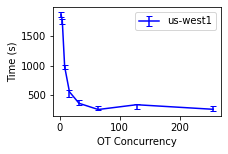

In [31]:
plt.figure(figsize = (3, 2))
    
benchmark_data = wan_ot_logs[0]["log"]["wan"]["oregon"][1]["merge_sorted"][1048576]

ot_concurrencies = (2, 4, 8, 16, 32, 64, 128, 256)
exec_times = []
for ot_concurrency in ot_concurrencies:
    ot_num_connections = 2
    ot_pipeline_depth = ot_concurrency // ot_num_connections
    data = benchmark_data[ot_pipeline_depth][ot_num_connections]["mage"]
    
    total_times = []
    for tag in ("t{0}".format(i) for i in itertools.count(start = 1)):
        if tag not in data["w0"]:
            break
        measurement = data["w0"][tag]
        total_times.append(measurement.total_time_ms / 1000.0)
    exec_times.append(np.percentile(total_times, (0, 25, 50, 75, 100)))

error_bars = ([stats[2] - stats[1] for stats in exec_times], [stats[3] - stats[2] for stats in exec_times])
plt.errorbar(ot_concurrencies, tuple(stats[2] for stats in exec_times), yerr = error_bars, capsize = errbarsize, **wan_oregon_style)

plt.legend()

plt.xlabel("OT Concurrency")
plt.ylabel("Time (s)")

plt.show()

WAN Experiments: Number of Connections
===================================

In [27]:
wan_conn_directory = "logs-wan-conn"

In [28]:
wan_conn_logs = parse_log_directory(wan_conn_directory)

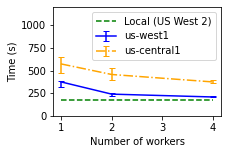

In [60]:
plt.figure(figsize = (3, 2))

ot_concurrency = 128
ot_num_connections = 1

num_workers = (1, 2, 4)
exec_times_by_loc = {}
for location in ("oregon", "iowa"):
    exec_times = []
    exec_times_by_loc[location] = exec_times
    for num_workers_per_node in num_workers:
        benchmark_data = wan_conn_logs[0]["log"]["wan"][location][num_workers_per_node]["merge_sorted"][1048576]
        ot_pipeline_depth = ot_concurrency // (ot_num_connections * num_workers_per_node)
        data = benchmark_data[ot_pipeline_depth][ot_num_connections]["mage"]

        total_times = []
        for tag in ("t{0}".format(i) for i in itertools.count(start = 1)):
            if tag not in data["w0"]:
                break
            measurements = []
            for worker_id in ("w{0}".format(i) for i in range(num_workers_per_node)):
                measurement = data[worker_id][tag]
                measurements.append(measurement.total_time_ms / 1000.0)
            total_times.append(np.max(measurements))
        exec_times.append(np.percentile(total_times, (0, 25, 50, 75, 100)))

error_bars = ([stats[2] - stats[1] for stats in exec_times_by_loc["oregon"]], [stats[3] - stats[2] for stats in exec_times_by_loc["oregon"]])
plt.errorbar(num_workers, tuple(stats[2] for stats in exec_times_by_loc["oregon"]), yerr = error_bars, capsize = errbarsize, **wan_oregon_style)
error_bars = ([stats[2] - stats[1] for stats in exec_times_by_loc["iowa"]], [stats[3] - stats[2] for stats in exec_times_by_loc["iowa"]])
plt.errorbar(num_workers, tuple(stats[2] for stats in exec_times_by_loc["iowa"]), yerr = error_bars, capsize = errbarsize, **wan_iowa_style)

plt.plot(num_workers, [174.5 for _ in num_workers], **wan_lan_style)

plt.legend()

plt.xlabel("Number of workers")
plt.ylabel("Time (s)")

plt.ylim(0, 1200)

plt.show()